## BBC News Classification

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

We will use matrix factorization to predict the category and apply Accuracy as a metric.

The content of this project includes exploratory data analysis (EDA) procedure, model building and training, and comparison with supervised learning. 

### 1. Exploratory Data Analysis (EDA)

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import itertools

In [82]:
train = pd.read_csv('BBC News Train.csv')
test = pd.read_csv('BBC News Test.csv')
sample_solution = pd.read_csv('BBC News Sample Solution.csv')

In [83]:
train.shape

(1490, 3)

In [84]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [86]:
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [87]:
sample_solution.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [88]:
# check for missing value in the train dataset
missing_values = train.isnull().sum()
# Display the count of missing values for each column
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
ArticleId    0
Text         0
Category     0
dtype: int64


In [89]:
# check for unique values in the train dataset
unique_counts = train.nunique()
print("Number of unique values per column:")
print(unique_counts)

Number of unique values per column:
ArticleId    1490
Text         1440
Category        5
dtype: int64


Text(0, 0.5, 'The Number of Documents')

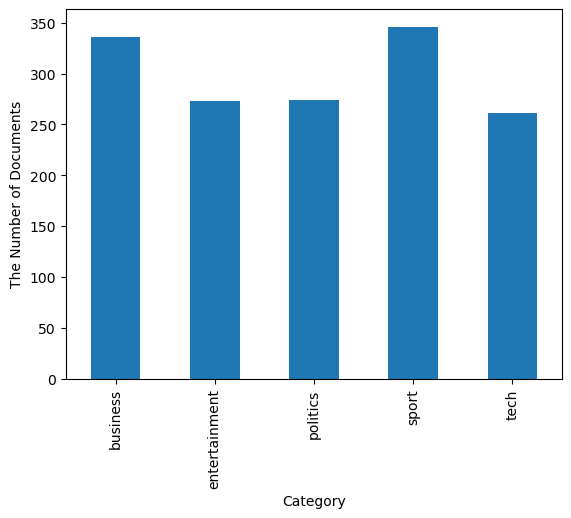

In [90]:
# Group by category
by_cat_count = train.groupby('Category')['ArticleId'].count()
by_cat_count.plot.bar(ylim=0)
plt.ylabel('The Number of Documents')

In [91]:
train.Text[0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [92]:
# Text processing removing punctuations, numbers and stopwords
# reference https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization?scriptVersionId=99448419&cellId=19
def clean_text(dataframe, text_col):
    '''
    A helper function which takes a dataframe 
    and removes punction and stopwords.
    '''
    #remove all punctuation
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    #remove numbers 
    dataframe['no_punct_num'] = dataframe['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #remove stopwords
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #remove extra spaces
    dataframe['clean_text'] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))
    return 

In [93]:
clean_text(train, 'Text')

In [94]:
train['clean_text'][0]

'worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant warnings led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates ms cooper runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom accounting early said andersen given green light procedures practices used worldcom mr ebber lawyers said unaware fraud arguing auditors alert problems ms cooper also said shareholder meetings mr ebbers often passed technical questions company finance chief giving brief answers prosecution star witness former worldcom fin

In [95]:
train.head()

,ArticleId,Text,Category,no_punct,no_punct_num,no_stopwords,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,german business confidence slides german busin...,german business confidence slides german busin...,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens maj...,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,enron bosses in m payout eighteen former enron...,enron bosses payout eighteen former enron dire...,enron bosses payout eighteen former enron dire...


Use lemmatization seeks to distill words to their foundational forms

In [96]:
def load_wordnet():
    nltk.download('wordnet')
    
load_wordnet()

# reference https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization?scriptVersionId=99448419&cellId=23
def lemmatizer(text):
    ''' 
    A helper function to lemmatize an entire sentence/string
    '''
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word.lower()) for word in text] 
    return lemma

def tokenize_lemmatize(dataframe, text_col):
    '''
    A helper function to tokenize then lemmatize the string.
    Also, add column which counts the number of words in that string.
    '''
    dataframe['tokenized'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    dataframe['lemmatized'] = dataframe['tokenized'].apply(lambda string: lemmatizer(string))
    dataframe['num_words'] = dataframe['lemmatized'].apply(lambda lst: len(lst))
    return

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zhong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [97]:
tokenize_lemmatize(train, 'clean_text')

In [98]:
train.head()

,ArticleId,Text,Category,no_punct,no_punct_num,no_stopwords,clean_text,tokenized,lemmatized,num_words
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",185
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,german business confidence slides german busin...,german business confidence slides german busin...,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",194
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens maj...,bbc poll indicates economic gloom citizens maj...,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...",267
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...,lifestyle governs mobile choice faster better ...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",344
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,enron bosses in m payout eighteen former enron...,enron bosses payout eighteen former enron dire...,enron bosses payout eighteen former enron dire...,"[enron, bosses, payout, eighteen, former, enro...","[enron, boss, payout, eighteen, former, enron,...",198


Overview of number of words per category

[Text(0.5, 1.0, 'Number of Words Per Category')]

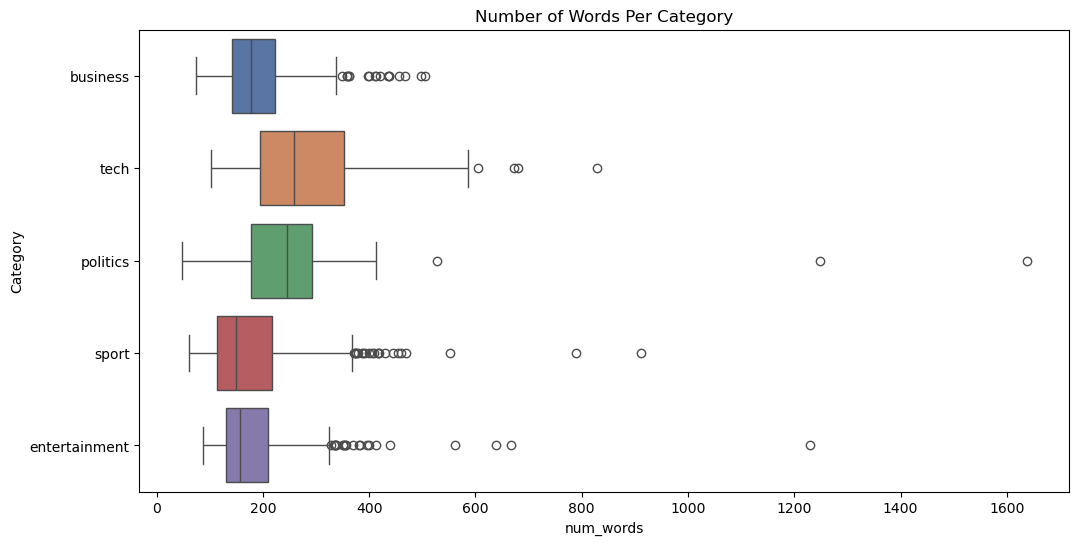

In [99]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = train, x = 'num_words', y = 'Category', hue = 'Category', palette = 'deep'
           ).set(title = 'Number of Words Per Category')

In [100]:
train.groupby('Category')['num_words'].max()

Category
business          505
entertainment    1230
politics         1638
sport             911
tech              829
Name: num_words, dtype: int64

### 2. Building and Training Models

Transform each article to a feature vector. Use the TF-IDF (Term Frequency-Inverse Document Frequency) to capture the importance of words within a document and across the entire dataset, This will creates a document-term matrix where rows represent documents and columns represent unique words.

In [101]:
# processing test dataset
clean_text(test, 'Text')
tokenize_lemmatize(test, 'clean_text')

In [102]:
test.head()

,ArticleId,Text,no_punct,no_punct_num,no_stopwords,clean_text,tokenized,lemmatized,num_words
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads for preston queens park r...,qpr keeper day heads for preston queens park r...,qpr keeper day heads preston queens park range...,qpr keeper day heads preston queens park range...,"[qpr, keeper, day, heads, preston, queens, par...","[qpr, keeper, day, head, preston, queen, park,...",86
1,1319,software watching while you work software that...,software watching while you work software that...,software watching while you work software that...,software watching work software monitor every ...,software watching work software monitor every ...,"[software, watching, work, software, monitor, ...","[software, watching, work, software, monitor, ...",232
2,1138,d arcy injury adds to ireland woe gordon d arc...,d arcy injury adds to ireland woe gordon d arc...,d arcy injury adds to ireland woe gordon d arc...,arcy injury adds ireland woe gordon arcy ruled...,arcy injury adds ireland woe gordon arcy ruled...,"[arcy, injury, adds, ireland, woe, gordon, arc...","[arcy, injury, add, ireland, woe, gordon, arcy...",135
3,459,india s reliance family feud heats up the ongo...,india s reliance family feud heats up the ongo...,india s reliance family feud heats up the ongo...,india reliance family feud heats ongoing publi...,india reliance family feud heats ongoing publi...,"[india, reliance, family, feud, heats, ongoing...","[india, reliance, family, feud, heat, ongoing,...",174
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...,"[boro, suffer, morrison, injury, blow, middles...","[boro, suffer, morrison, injury, blow, middles...",71


In [103]:
# create vectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec.fit(train['clean_text'])
tfidvec_train = tfidvec.transform(train['clean_text'])
tfidvec_test = tfidvec.transform(test['clean_text'])

In [104]:
print('train_shape', tfidvec_train.shape)
print('test_shape', tfidvec_test.shape)

train_shape (1490, 13971)
test_shape (735, 13971)


#### Non-Negative Matrix Factorization (NMF)

Apply NMF to the document-term matrix. NMF decomposes the matrix into two lower-dimensional matrices:
* W (n_samples * n_components): A document-topic matrix, where each row represents a document and each column represents a topic. The values in this matrix indicate the weights (or contributions) of each topic to a particular document.
* H (n_components * n_features): A topic-term matrix, where each row reprents a topic and each column rpresents a word. The values in this matrix indicate the importance of each word for describing a particular topic.

In [105]:
num_cat = 5
nmf_model = NMF(n_components = num_cat, random_state = 7)
nmf_model.fit(tfidvec_train)
w_mat = nmf_model.transform(tfidvec_train)
print('Shape of doc-topic mat:','\n',w_mat.shape)
h_mat = nmf_model.components_
print('Shape of doc-topic mat:','\n',h_mat.shape)
print(w_mat[0])

Shape of doc-topic mat: 
 (1490, 5)
Shape of doc-topic mat: 
 (5, 13971)
[0.         0.03577532 0.00559371 0.00144951 0.06162621]


Document with highest value in a specific column of W is most relevant to that particular topic. Use argmax() to identify the topic of each article.

In [106]:
nmf_predictions = w_mat.argmax(axis = 1)

#### Label Permutation

The predicted label based on index ranging from 0 to 4 so the label does not match with five categories (e.g. sport, tech, business, entertainment and politics). Write a helper function to find best matching label ordering based on accuracy.

In [107]:
def label_permute_compare(ytdf, yp,n):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    n: the number of classes
    Returns label dictionary, permuted label order and accuracy. 
    Example output: {'business': 4, 'tech' : 2...}, (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    df_labels = np.unique(ytdf).tolist() # the true labels
    p_labels = np.unique(yp).tolist() # the random labels from prediction

    # generate all possible permutations of predicted labels
    # {'business': 4, 'tech' : 2...}
    dict_perm_lst = []
    for perm in itertools.permutations(list(range(n))):
        dict_perm_lst.append(dict(zip(df_labels, perm))) 

    # find the mapping yielding best accuracy
    best_acc = 0
    labelorder = []
    for dict_perm in dict_perm_lst:
        yt_mapped = []
        for elt in ytdf:
            yt_mapped.append(dict_perm[elt])
        acc = accuracy_score(yt_mapped, yp)
        if acc > best_acc:
            best_acc = acc
            labelorder = list(dict_perm.values())
            labeldict = dict_perm

    return labeldict, labelorder, best_acc

In [108]:
labeldict, labelorder, best_acc = label_permute_compare(train['Category'], nmf_predictions, n = num_cat)
print('Accuracy: ', best_acc)
print('Label dictionary:', labeldict)

Accuracy:  0.9167785234899329
Label dictionary: {'business': 4, 'entertainment': 3, 'politics': 1, 'sport': 0, 'tech': 2}


#### Hyperparameter Tuning (NMF)

After playing around with solver and beta_loss in NMF. The following combination yields best accuracy

In [109]:
nmf_model = NMF(n_components = num_cat, init='nndsvda', solver = 'mu', beta_loss = 'kullback-leibler', random_state = 7)
nmf_model.fit(tfidvec_train)
w_mat = nmf_model.transform(tfidvec_train)
h_mat = nmf_model.components_
nmf_predictions = w_mat.argmax(axis = 1)
nmf_labeldict, nmf_labelorder, nmf_best_acc = label_permute_compare(train['Category'], nmf_predictions, n = num_cat)
print('Accuracy: ', nmf_best_acc)
print('Label dictionary:', nmf_labeldict)

Accuracy:  0.9604026845637584
Label dictionary: {'business': 4, 'entertainment': 3, 'politics': 1, 'sport': 0, 'tech': 2}


{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}


Text(95.72222222222221, 0.5, 'True Labels')

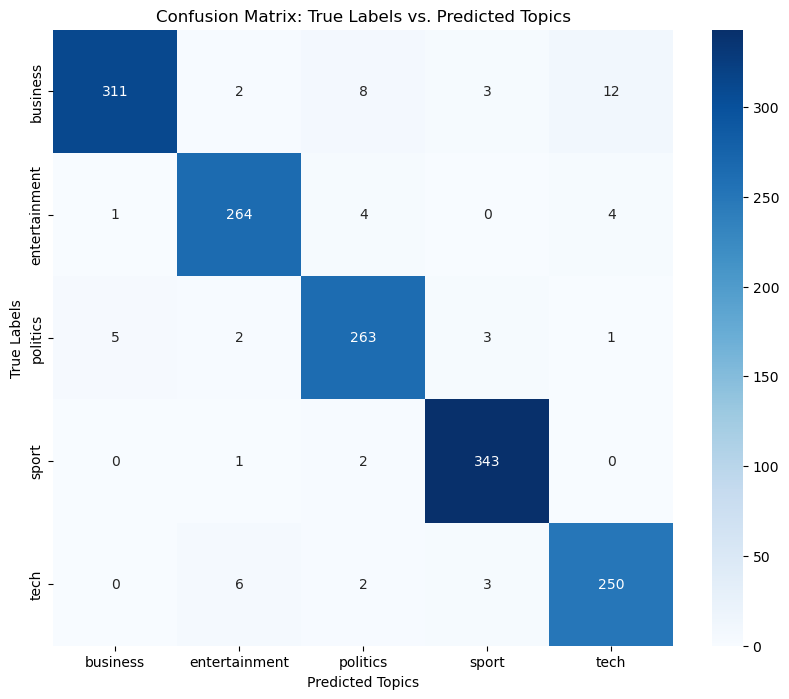

In [110]:
# Confusion Matrix
rev_labeldict = {}
for i in range(num_cat):
    category = [key for key in labeldict if labeldict[key] == i]
    rev_labeldict[i] = category[0]
print(rev_labeldict)

pred_label = [rev_labeldict[label] for label in nmf_predictions]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(train.Category, pred_label), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=labeldict.keys(), yticklabels=labeldict.keys())
plt.title('Confusion Matrix: True Labels vs. Predicted Topics')
plt.xlabel('Predicted Topics')
plt.ylabel('True Labels')

#### Use the NMF model above to predict test data

In [111]:
test_w_mat = nmf_model.transform(tfidvec_test)
# test_h_mat = nmf_model.components_
test_nmf_predictions = test_w_mat.argmax(axis = 1)
test_pred_label = [rev_labeldict[label] for label in test_nmf_predictions]
test_preds = pd.DataFrame(columns=["ArticleId", "Category"])
test_preds["ArticleId"] = test.ArticleId
test_preds["Category"] = test_pred_label
test_preds.to_csv("submission.csv", index=False)
print('Accuracy based on Kaggle submission is 0.9605 using NMF')

Accuracy based on Kaggle submission is 0.9605 using NMF


#### Truncated SVD

Use single value decomposition (SVD). I tried tuning hyperparameters and the following combination yields best accuracy. 

In [112]:
tsvd = TruncatedSVD(n_components = num_cat, algorithm = 'randomized', random_state = 7).fit(tfidvec_train)
X_transformed = tsvd.transform(tfidvec_train)
Vt = tsvd.components_
S = tsvd.singular_values_
U = X_transformed / S
print('VT:', Vt.shape)
print('S: ', S)
print('U: ', U.shape)

VT: (5, 13971)
S:  [6.17255715 4.06640783 3.67458557 3.50128516 3.34951605]
U:  (1490, 5)


In [114]:
svd_predictions = U.argmax(axis = 1)
svd_labeldict, svd_labelorder, svd_best_acc = label_permute_compare(train['Category'], svd_predictions, n = num_cat)
print('Accuracy: ', svd_best_acc)
print('Label dictionary:', svd_labeldict)

Accuracy:  0.661744966442953
Label dictionary: {'business': 4, 'entertainment': 3, 'politics': 1, 'sport': 2, 'tech': 0}


Comparing with NMF, single value decomposition has much lower accuracy becasue it mislabeled categories of sprots and tech.

### 3. Comparison with Supervised Learning

Typically, supervised learning yields good performance for classification problem. It's interesting to compare the accuracy of matrix factorization model with that of supervised learning model. I will use Logistic Regression and Random Forest as the benchmarks.

#### Logistic Regression

In [116]:
# LogisticRegression
clf = LogisticRegression(random_state=7).fit(tfidvec_train, train['Category'])
clf_predicitons = clf.predict(tfidvec_train)
print(clf.score(tfidvec_train, train['Category']))

0.9966442953020134


In [117]:
# preprocessing test dataset
test = pd.read_csv('BBC News Test.csv')
sample_solution = pd.read_csv('BBC News Sample Solution.csv')
clean_text(test, 'Text')
tokenize_lemmatize(test, 'clean_text')

In [118]:
clf_predicitons = clf.predict(tfidvec_test)
test_preds = pd.DataFrame(columns=["ArticleId", "Category"])
test_preds["ArticleId"] = test.ArticleId
test_preds["Category"] = clf_predicitons
test_preds.to_csv("submission_LG.csv", index=False)
print('Accuracy based on Kaggle submission is 0.978 using logistic regression')

Accuracy based on Kaggle submission is 0.978 using logistic regression


The Logistic Regression has higher accuracy then NMF model on both training and testing data.

#### Random Forest

In [131]:
rf_model = RandomForestClassifier(n_estimators = 200, max_features = 'sqrt', random_state = 7)
rf_model.fit(tfidvec_train, train['Category'])
rf_predictions = rf_model.predict(tfidvec_train)
print(rf_model.score(tfidvec_train, train['Category']))

1.0


In [133]:
rf_predictions = rf_model.predict(tfidvec_test)
test_preds = pd.DataFrame(columns=["ArticleId", "Category"])
test_preds["ArticleId"] = test.ArticleId
test_preds["Category"] = rf_predictions
test_preds.to_csv("submission_RF.csv", index=False)
print('Accuracy based on Kaggle submission is 0.967 using logistic regression')

Accuracy based on Kaggle submission is 0.967 using logistic regression


The Random Forest also has higher accuracy then NMF model on both training and testing data but not as good as Logistic Regression.